In [1]:
'''!pip install aicrowd-cli
API_KEY = "9967b67c796b4d50e5d26f4dfd97ed06" 
!aicrowd login --api-key $API_KEY
!aicrowd dataset download --challenge global-wheat-challenge-2021'''

'!pip install aicrowd-cli\nAPI_KEY = "9967b67c796b4d50e5d26f4dfd97ed06" \n!aicrowd login --api-key $API_KEY\n!aicrowd dataset download --challenge global-wheat-challenge-2021'

In [2]:
'''import shutil
shutil.copyfile('/content/train.zip',
                '/content/drive/MyDrive/aicrowd_wheat/train.zip')
shutil.copyfile('/content/test.zip',
                '/content/drive/MyDrive/aicrowd_wheat/test.zip')
shutil.copyfile('/content/submission.csv',
                '/content/drive/MyDrive/aicrowd_wheat/submission.csv')'''

"import shutil\nshutil.copyfile('/content/train.zip',\n                '/content/drive/MyDrive/aicrowd_wheat/train.zip')\nshutil.copyfile('/content/test.zip',\n                '/content/drive/MyDrive/aicrowd_wheat/test.zip')\nshutil.copyfile('/content/submission.csv',\n                '/content/drive/MyDrive/aicrowd_wheat/submission.csv')"

In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Fri Jun 18 07:14:29 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!pip install -q albumentations==0.4.6
!pip install mlflow

     |████████████████████████████████| 122kB 13.1MB/s 
     |████████████████████████████████| 952kB 26.9MB/s 
     |████████████████████████████████| 14.2MB 410kB/s 
     |████████████████████████████████| 153kB 40.7MB/s 
     |████████████████████████████████| 81kB 8.6MB/s 
     |████████████████████████████████| 174kB 42.8MB/s 
     |████████████████████████████████| 1.1MB 32.4MB/s 
     |████████████████████████████████| 61kB 8.2MB/s 
     |████████████████████████████████| 71kB 8.9MB/s 
     |████████████████████████████████| 71kB 8.7MB/s 
     |████████████████████████████████| 81kB 9.4MB/s 
  Created wheel for prometheus-flask-exporter: filename=prometheus_flask_exporter-0.18.2-cp37-none-any.whl size=17415 sha256=a46b3c0c082a437f87ca532f5a672a8717d00122c5b8f16d789ebfd0a7341b09
  Stored in directory: /root/.cache/pip/wheels/c0/e2/9c/4f3ee23964802940f81a8b476d0b9be6fb6348cb12df2e2226
  Created wheel for alembic: filename=alembic-1.4.1-py2.py3-none-any.whl size=158170 sha256=57ee6

In [6]:
import shutil
import pandas as pd
import numpy as np 
import os
import cv2
import re

from PIL import Image
import random

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN  
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt
from datetime import datetime

from sklearn.model_selection import StratifiedKFold, train_test_split
import joblib
import mlflow

In [7]:
from torchvision.models.detection._utils import Matcher
from torchvision.ops.boxes import box_iou

def accuracy(src_boxes, pred_boxes,  iou_threshold = 1.):
  """
  The accuracy method is not the one used in the evaluator but very similar
  """
  total_gt = len(src_boxes)
  total_pred = len(pred_boxes)
  if total_gt > 0 and total_pred > 0:


    # Define the matcher and distance matrix based on iou
    matcher = Matcher(iou_threshold,iou_threshold,allow_low_quality_matches=False) 
    match_quality_matrix = box_iou(src_boxes,pred_boxes)

    results = matcher(match_quality_matrix)
    
    true_positive = torch.count_nonzero(results.unique() != -1)
    matched_elements = results[results > -1]
    
    #in Matcher, a pred element can be matched only twice 
    false_positive = torch.count_nonzero(results == -1) + ( len(matched_elements) - len(matched_elements.unique()))
    false_negative = total_gt - true_positive

        
    return  true_positive / ( true_positive + false_positive + false_negative )

  elif total_gt == 0:
      if total_pred > 0:
          return torch.tensor(0.).cuda()
      else:
          return torch.tensor(1.).cuda()
  elif total_gt > 0 and total_pred == 0:
      return torch.tensor(0.).cuda()

In [8]:
if(os.path.isdir('test')):
  print('folder exists, skip unzip procedure')
else:
  shutil.copyfile('/content/drive/MyDrive/aicrowd_wheat/test.zip','/content/test.zip')
  shutil.unpack_archive('./test.zip')
  #!unzip train.zip

In [9]:
len(os.listdir('./test/')), os.listdir('./test/')[0:3]

(2856,
 ['7f11bd788fc490e8cbe7b3b1d18fbfa887502a4c42337494bc4ec00d7f5ee334.png',
  'fd1e7c76adcae243027568ed6231492fd29fa49253a72a44af44b56f2aaae32a.png',
  '55f579f4d3407974fc8350b6074e355515556b06efdd8f0e100fee1b424a099e.png'])

In [10]:
df_train = pd.read_csv('/content/drive/MyDrive/aicrowd_wheat/yolov5/best_submission_1.csv')
df_train['BoxesString'] =  df_train['PredString']
df_train['image_id'] = df_train['image_name']
df_train['has_no_boxes'] = np.where(df_train['BoxesString']=='no_box',1,0)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2849 entries, 0 to 2848
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   image_name    2849 non-null   object
 1   PredString    2849 non-null   object
 2   domain        2849 non-null   int64 
 3   BoxesString   2849 non-null   object
 4   image_id      2849 non-null   object
 5   has_no_boxes  2849 non-null   int64 
dtypes: int64(2), object(4)
memory usage: 133.7+ KB


In [11]:
df_train['has_no_boxes'].sum()*100/df_train.shape[0]

0.8775008775008775

In [12]:
df_noboxes = df_train.groupby(['domain'])['has_no_boxes'].agg(['sum','count']).reset_index()
df_noboxes['perc'] = df_noboxes['sum']*100/df_noboxes['count']
df_noboxes

,domain,sum,count,perc
0,18,0,20,0.000000
1,19,4,120,3.333333
2,20,0,538,0.000000
3,21,0,456,0.000000
4,22,0,200,0.000000
5,23,0,22,0.000000
6,24,13,16,81.250000
7,25,2,14,14.285714
8,26,0,30,0.000000
9,27,0,30,0.000000


In [13]:
df_train[df_train.BoxesString=='no_box'].shape[0], \
df_train[df_train.BoxesString=='no_box'].shape[0]*100/df_train.shape[0]

(25, 0.8775008775008775)

### Filter images with multiple domains

In [14]:
tf = df_train[['image_id','domain']].groupby(['image_id']).count().reset_index()
domain_lkup = df_train[~df_train.image_id.isin(tf[tf.domain>1].image_id.values)][['image_id','domain']]
tf[tf.domain>1].image_id.values

array(['fc34c741f16631a746c8764afb723d43083d321b1d8d96239720895acf67881f'],
      dtype=object)

In [15]:
df_train_final = pd.concat([pd.Series(row['image_id'], row['BoxesString'].split(';')) \
                            for _, row in df_train[df_train.BoxesString!='no_box'].iterrows()]).reset_index()
df_train_final.columns = ['box','image_id']
df_train_final['x_min'] = df_train_final.box.apply(lambda x:x.split(' ')[0]).apply(int)
df_train_final['y_min'] = df_train_final.box.apply(lambda x:x.split(' ')[1]).apply(int)
df_train_final['x_max'] = df_train_final.box.apply(lambda x:x.split(' ')[2]).apply(int)
df_train_final['y_max'] = df_train_final.box.apply(lambda x:x.split(' ')[3]).apply(int)
df_train_final['x'] = df_train_final['x_min']
df_train_final['y'] = df_train_final['y_min']
df_train_final['w'] = df_train_final['x_max'] - df_train_final['x_min']
df_train_final['h'] = df_train_final['y_max'] - df_train_final['y_min']
df_train_final = df_train_final.merge(domain_lkup, on=['image_id'], how='left')
df_train_final.fillna(-1, inplace=True)
df_train_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 81986 entries, 0 to 81985
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   box       81986 non-null  object 
 1   image_id  81986 non-null  object 
 2   x_min     81986 non-null  int64  
 3   y_min     81986 non-null  int64  
 4   x_max     81986 non-null  int64  
 5   y_max     81986 non-null  int64  
 6   x         81986 non-null  int64  
 7   y         81986 non-null  int64  
 8   w         81986 non-null  int64  
 9   h         81986 non-null  int64  
 10  domain    81986 non-null  float64
dtypes: float64(1), int64(8), object(2)
memory usage: 7.5+ MB


In [16]:
df_train_final.head()
# df_train.domain.value_counts()

,box,image_id,x_min,y_min,x_max,y_max,x,y,w,h,domain
0,849 303 925 386,c087c8b89904edee56997a25d64f4cd1b7c9441e64889a...,849,303,925,386,849,303,76,83,18.0
1,254 372 313 445,c087c8b89904edee56997a25d64f4cd1b7c9441e64889a...,254,372,313,445,254,372,59,73,18.0
2,808 598 881 634,c087c8b89904edee56997a25d64f4cd1b7c9441e64889a...,808,598,881,634,808,598,73,36,18.0
3,547 49 616 118,c087c8b89904edee56997a25d64f4cd1b7c9441e64889a...,547,49,616,118,547,49,69,69,18.0
4,966 698 1024 755,c087c8b89904edee56997a25d64f4cd1b7c9441e64889a...,966,698,1024,755,966,698,58,57,18.0


In [17]:
DIR_INPUT = './'
DIR_TRAIN = f'{DIR_INPUT}/test'
DIR_TEST = f'{DIR_INPUT}/test'

In [18]:
'''train_set, test_set = train_test_split(df_train.image_id.values, test_size=0.2, random_state=42)
train_set.shape, test_set.shape
joblib.dump(train_set, '/content/drive/MyDrive/aicrowd_wheat/train_set')
joblib.dump(test_set, '/content/drive/MyDrive/aicrowd_wheat/test_set')
kfold = StratifiedKFold(n_splits=5)
folds = []
for train_ids, test_ids in kfold.split(df_train.image_id.values, df_train.domain.values):
  folds.append([df_train.image_id.values[train_ids], df_train.image_id.values[test_ids]])
joblib.dump(folds, '/content/drive/MyDrive/aicrowd_wheat/kfolds')'''

"train_set, test_set = train_test_split(df_train.image_id.values, test_size=0.2, random_state=42)\ntrain_set.shape, test_set.shape\njoblib.dump(train_set, '/content/drive/MyDrive/aicrowd_wheat/train_set')\njoblib.dump(test_set, '/content/drive/MyDrive/aicrowd_wheat/test_set')\nkfold = StratifiedKFold(n_splits=5)\nfolds = []\nfor train_ids, test_ids in kfold.split(df_train.image_id.values, df_train.domain.values):\n  folds.append([df_train.image_id.values[train_ids], df_train.image_id.values[test_ids]])\njoblib.dump(folds, '/content/drive/MyDrive/aicrowd_wheat/kfolds')"

In [19]:
train_images = joblib.load('/content/drive/MyDrive/aicrowd_wheat/train_set')
test_images = joblib.load('/content/drive/MyDrive/aicrowd_wheat/test_set')
kfold_images = joblib.load('/content/drive/MyDrive/aicrowd_wheat/kfolds')
train_images.shape, test_images.shape, len(kfold_images)

((2925,), (732,), 5)

In [20]:
# valid_df = df_train_final[df_train_final['image_id'].isin(test_images)]
train_df = df_train_final.copy(deep=True)#[df_train_final['image_id'].isin(train_images)]
# valid_df.shape, 
train_df.shape

(81986, 11)

In [21]:
class WheatDataset(Dataset):

    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]

        image = cv2.imread(f'{self.image_dir}/{image_id}.png', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        boxes = records[['x', 'y', 'w', 'h']].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)

        # there is only one class
        labels = torch.ones((records.shape[0],), dtype=torch.int64)
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        # target['masks'] = None
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd

        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)

        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [22]:
'''def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
'''

def get_train_transform():
    return A.Compose([
                      A.ToGray(p=0.5),
                      A.Flip(p=0.5),
                      A.RandomBrightnessContrast(p=0.5),
                      A.Cutout(num_holes= random.randint(10, 20), max_h_size= 64, max_w_size =64, p = 0.40),
                      ToTensorV2(p=1.0)
                      ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def collate_fn(batch):
    return tuple(zip(*batch))

## Train Model

In [23]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, pretrained_backbone=False)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 2  # 1 class (wheat) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Load the trained weights
model.load_state_dict(torch.load('/content/drive/MyDrive/aicrowd_wheat/'\
                                 +'fasterrcnn_resnet50_epochs_40_lr_0.005_time_13_06_2021_21_23.pth'))

<All keys matched successfully>

In [24]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

### Full dataset train

In [25]:
# train_dataset = WheatDataset(train_df, DIR_TRAIN, get_train_transform())
train_dataset = WheatDataset(df_train_final, DIR_TRAIN, get_train_transform())
# valid_dataset = WheatDataset(valid_df, DIR_TRAIN, get_valid_transform())

# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()

train_data_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

'''valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)'''

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


'valid_data_loader = DataLoader(\n    valid_dataset,\n    batch_size=8,\n    shuffle=False,\n    num_workers=4,\n    collate_fn=collate_fn\n)'

In [26]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


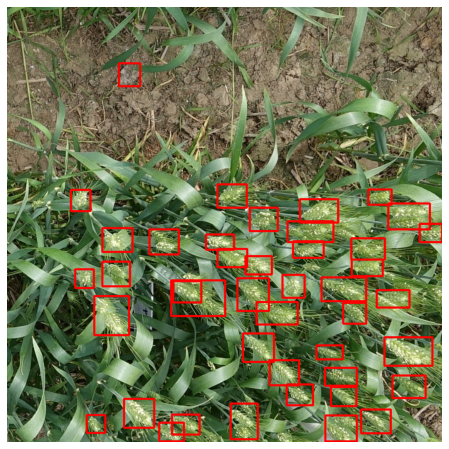

In [27]:
images, targets, image_ids = next(iter(train_data_loader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
boxes = targets[1]['boxes'].cpu().numpy().astype(np.int32)
sample = images[1].permute(1,2,0).cpu().numpy()
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)
    
ax.set_axis_off()
ax.imshow(sample)

In [28]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
lr_rate=0.005
optimizer = torch.optim.SGD(params, lr=lr_rate, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
# lr_scheduler = None

num_epochs = 10

In [29]:
loss_hist = Averager()
itr = 1
loss_plot = []

for epoch in range(num_epochs):
    loss_hist.reset()
    
    for images, targets, image_ids in train_data_loader:
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if itr % 50 == 0:
            print(f"Iteration #{itr} loss: {loss_value}")

        itr += 1
    
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()

    print(f"Epoch #{epoch} loss: {loss_hist.value}")  
    loss_plot.append(loss_hist.value)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Iteration #50 loss: 0.32070379484049905
Iteration #100 loss: 0.3416877435555661
Iteration #150 loss: 0.58544884273215
Epoch #0 loss: 0.4538354970642014
Iteration #200 loss: 0.3159021106151867
Iteration #250 loss: 0.3911562820128267
Iteration #300 loss: 0.6989107639844546
Iteration #350 loss: 0.5497033392581187
Epoch #1 loss: 0.4073899700919392
Iteration #400 loss: 0.25768987422302775
Iteration #450 loss: 0.362142292365192
Iteration #500 loss: 0.36144883129597877
Epoch #2 loss: 0.3929772182246818
Iteration #550 loss: 0.29317186132610806
Iteration #600 loss: 0.29029576471951174
Iteration #650 loss: 0.36442612840516025
Iteration #700 loss: 0.3963773111041159
Epoch #3 loss: 0.37640013190357446
Iteration #750 loss: 0.26167404276067097
Iteration #800 loss: 0.4485590188438692
Iteration #850 loss: 0.3327585811468175
Epoch #4 loss: 0.36352896526716844
Iteration #900 loss: 0.3000400466043743
Iteration #950 loss: 0.25983319656058773
Iteration #1000 loss: 0.3132295390142843
Iteration #1050 loss: 0

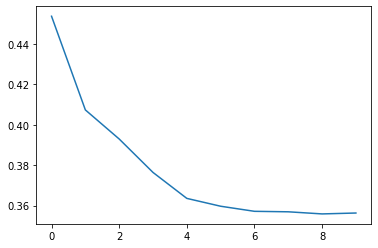

In [30]:
plt.plot(loss_plot)

In [31]:
filename = 'fasterrcnn_resnet50_epochs_'+str(num_epochs)+'_lr_'+str(lr_rate)+'_time_'+datetime.now().strftime(format='%d_%m_%Y_%H_%M')+'.pth'
torch.save(model.state_dict(), '/content/drive/MyDrive/aicrowd_wheat/'+filename)

## Evaluation

In [ ]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, pretrained_backbone=False)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
valid_dataset = WheatDataset(valid_df, DIR_TRAIN, get_valid_transform())
valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn,
    drop_last=False
)

num_classes = 2  # 1 class (wheat) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Load the trained weights
model.load_state_dict(torch.load('/content/drive/MyDrive/aicrowd_wheat/'\
                                 +'fasterrcnn_resnet50_epochs_40_lr_0.005_time_13_06_2021_21_23.pth'))
model.eval()
x = model.to(device)

NameError: ignored

In [ ]:
device

In [ ]:
results = []

for images, targets, image_ids in valid_data_loader:
  images = list(img.to(device) for img in images)
  outputs = model(images)
  # outputs = [{k: v.to('cpu') for k, v in t.items()} for t in outputs]
  results.append([image_ids[0], targets[0], 
                  outputs[0]['boxes'].cpu().detach().numpy(), outputs[0]['scores'].cpu().detach().numpy()])

len(results)

In [ ]:
threshold = 0.6
performance = []
for row in results:
  image_id = row[0]
  actuals = row[1]['boxes']#.cpu().numpy().astype(np.int32)
  scores = row[3]
  predictions = row[2][scores>=threshold]
  acc = accuracy(torch.from_numpy(predictions), actuals, iou_threshold = .5)
  acc = np.float(acc.detach().cpu().numpy())
  performance.append([image_id, acc])
  
print(len(performance))
df_performance = pd.DataFrame(performance, columns=['image_id','acc'])
df_performance.acc.mean()

#### 20 Epochs 0.7653925410826892

In [ ]:
for threshold in np.arange(0,1,0.05):
  performance = []
  for row in results:
    image_id = row[0]
    actuals = row[1]['boxes']#.cpu().numpy().astype(np.int32)
    scores = row[3]
    predictions = row[2][scores>=threshold]
    acc = accuracy(torch.from_numpy(predictions), actuals, iou_threshold = .5)
    acc = np.float(acc.detach().cpu().numpy())
    performance.append([image_id, acc])
    df_performance = pd.DataFrame(performance, columns=['image_id','acc'])
    acc = df_performance.acc.mean()
    #mlflow.log_param("threshold", threshold)
    #mlflow.log_param("num_epochs", num_epochs)
    #mlflow.log_param("lr_rate", lr_rate)
    #mlflow.log_metric("accuracy", acc)
  print('threshold:',round(threshold,2),', acc:',round(acc,4))

In [ ]:
# shutil.copytree('/content/mlruns/','/content/drive/MyDrive/aicrowd_wheat/mlruns/')

In [ ]:
images, targets, image_ids = next(iter(valid_data_loader))
images = list(img.to(device) for img in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
boxes = targets[0]['boxes'].cpu().numpy().astype(np.int32)
sample = images[0].permute(1,2,0).cpu().numpy()
model.eval()
cpu_device = torch.device("cpu")
outputs = model(images)
outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]


fig, ax = plt.subplots(1, 1, figsize=(16, 8))
boxes = outputs[0]['boxes'].detach().numpy()
scores = outputs[0]['scores'].detach().numpy()
boxes = boxes[scores>=0.5]
for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)
    
ax.set_axis_off()
ax.imshow(sample)

In [ ]:
shutil.copyfile('/content/train.csv',
                '/content/drive/MyDrive/aicrowd_wheat/train.csv')

In [ ]:
while True:
  pass